Import libraries and Get Weather Station Info available from Met Eireann. 

In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point
import requests
#import wget
from zipfile import ZipFile

#Get Weather Stations details available from Met Eireann 
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head
print(wsdf.dtypes)

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year        object
close year       object
dtype: object


The Values in 'open year' and 'close year' are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '300' and convert to int.
This allows us to filter the data based on Year

In [3]:
#Convert Values in 'open year' and 'close year' from '(null)' to future year '3000'
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].astype(int)
print(wsdf.dtypes)
#Filter Weather Stations to those reporting data fdrom 2010 to the present
ltywsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2011)]
ltywsdf.head

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year         int32
close year        int32
dtype: object


<bound method NDFrame.head of        county  station name                             name  height(m)  \
0      Antrim          5880                  LH_RATHLIN_WEST         10   
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

Verify the stations have a satisfactory geographical distribution by plotting the latitude and longitude

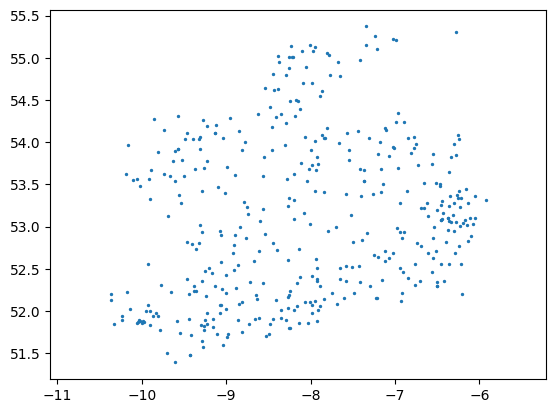

In [10]:
plt.scatter(x=ltywsdf['longitude'],y=ltywsdf['latitude'],s=2)
plt.axis('equal')

plt.show()


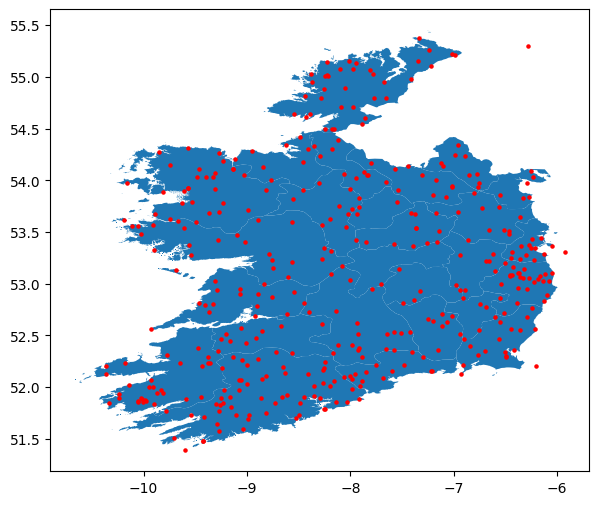

In [4]:
IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')  #reading the map 
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

Remove Rathlin Island Station from dataframe as it is not in scope here

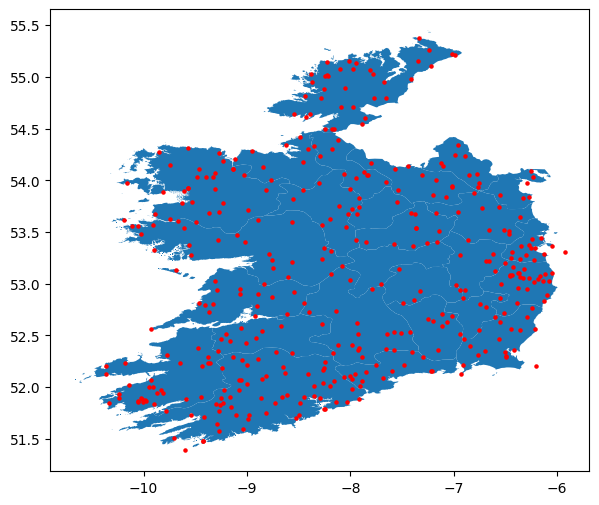

In [5]:
ltywsdf = ltywsdf.loc[ltywsdf["name"] != 'LH_RATHLIN_WEST']
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);

https://cli.fusio.net/cli/climate_data/webdata/hly375.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly675.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly518.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly775.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly3904.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly1075.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly575.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly1575.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly2075.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly3723.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly175.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly532.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly275.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly1875.zip is found
https://cli.fusio.net/cli/climate_data/webdata/hly2275.z

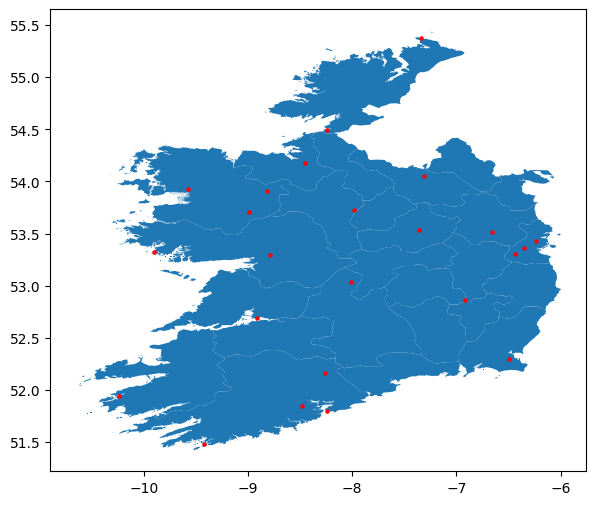

In [17]:
def url_checker(url):
	try:
		#Get Url
		get = requests.get(url)
		# if the request succeeds 
		if get.status_code == 200:
			return True
		else:
			return False
	#Exception
	except requests.exceptions.RequestException as e:
        # print URL with Errs
		return False

baseurl='https://cli.fusio.net/cli/climate_data/webdata/hly'
basefile='./weatherstationdata/hly'
for station in ltywsdf['station name']:
    stationurl=baseurl+str(station)+'.zip'
    stationfile=basefile+str(station)+'.zip'
    if url_checker(stationurl):
        response = requests.get(stationurl)
        open(stationfile, "wb").write(response.content)
        print(f"{stationurl} is found")
    else:
        ltywsdf = ltywsdf.loc[ltywsdf["station name"] != station]

geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=5);	
    #stationfile=basefile+str(station)+'.zip'
    #response = requests.get(stationurl)
    #open(stationfile, "wb").write(response.content)
    #response = wget.download(stationurl,stationfile)
    #break

For each file in ./weatherstationdata unzip the archive
with file hly*.csv 
Find  'date:' and for each line until blank line create a dictionary
Find column headers starting with date, and read the rest of the file into dataframe
Rename the columns as per the dictionary
Delete unused columns
  

In [29]:
#Start with a single file
#Put in a loop here
stationzipfile='./weatherstationdata/hly575.zip'
stationzipfolder=stationzipfile[:-4]
print(stationzipfolder)
#with ZipFile(stationzipfile, 'r') as zip_ref:
#        zip_ref.extractall(stationzipfolder)
weatherdatafile=stationzipfolder+'/'+stationzipfolder.split("/")[2]+'.csv'
with open(weatherdatafile, 'r') as wf:
    for lineno, line in enumerate(wf):
        if 'date:' in line:
            inblock=True
            print('string found in a file')
            print('Line Number:', lineno)
            print('Line:', line)
            # don't look for next lines
            #Add into Dictionary
        else:
            if 
            break
    #lines=list(scores_files.readlines())
    #while line[lineno].strip():
    print(wf[lineno])
#if line.strip():
#lineno
""" search_text = input("Search For Product (Name Or Code):\n")
with io.open('/home/jake/Projects/Stock','r', encoding='utf8') as f:
    for line in f:
        if search_text == line.strip():
            print line
            break
    else:
        print 'Search text not found' """




./weatherstationdata/hly575
string found in a file
Line Number: 5
Line: date:  -  Date and Time (utc)



TypeError: '_io.TextIOWrapper' object is not subscriptable